In [2]:
pip install opendatasets --upgrade

In [3]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/dmitrybabko/speech-emotion-recognition-en?q=speech+emotion+recognition+dataset')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: vikasverma13mp
Your Kaggle Key: ··········


100%|██████████| 987M/987M [00:10<00:00, 99.8MB/s]


In [4]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/content/speech-emotion-recognition-en'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Streaming output truncated to the last 5000 lines.
/content/speech-emotion-recognition-en/Crema/1061_TAI_SAD_XX.wav
/content/speech-emotion-recognition-en/Crema/1049_TAI_FEA_XX.wav
/content/speech-emotion-recognition-en/Crema/1015_TIE_NEU_XX.wav
/content/speech-emotion-recognition-en/Crema/1088_TIE_ANG_XX.wav
/content/speech-emotion-recognition-en/Crema/1041_IWL_FEA_XX.wav
/content/speech-emotion-recognition-en/Crema/1080_TSI_DIS_XX.wav
/content/speech-emotion-recognition-en/Crema/1060_ITH_HAP_XX.wav
/content/speech-emotion-recognition-en/Crema/1014_IWL_NEU_XX.wav
/content/speech-emotion-recognition-en/Crema/1024_WSI_NEU_XX.wav
/content/speech-emotion-recognition-en/Crema/1072_DFA_HAP_XX.wav
/content/speech-emotion-recognition-en/Crema/1079_TSI_FEA_XX.wav
/content/speech-emotion-recognition-en/Crema/1056_IWL_SAD_XX.wav
/content/speech-emotion-recognition-en/Crema/1080_IWW_DIS_XX.wav
/content/speech-emotion-recognition-en/Crema/1070_ITS_DIS_XX.wav
/content/speech-emotion-recognition-en/

In [6]:
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.io import wavfile
import os.path
import IPython.display
import IPython.display as ipd
import seaborn as sns
import librosa
import librosa.display
import soundfile

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from keras import optimizers
from keras.utils import np_utils
from keras import callbacks
from keras.callbacks import ReduceLROnPlateau


import warnings

In [14]:
image_dir = Path('/content/speech-emotion-recognition-en/Crema')

In [15]:
filepaths = list(image_dir.glob(r'**/*.wav'))

In [16]:
labels = list(map(lambda x: os.path.split(x)[1].split('_')[2], filepaths))
set(labels)

{'ANG', 'DIS', 'FEA', 'HAP', 'NEU', 'SAD'}

In [17]:
filepaths = pd.Series(filepaths, name='file_path').astype(str)
labels = pd.Series(labels, name='label')

audio_df = pd.concat([filepaths, labels], axis=1)
audio_df

,file_path,label
0,/content/speech-emotion-recognition-en/Crema/1...,FEA
1,/content/speech-emotion-recognition-en/Crema/1...,ANG
2,/content/speech-emotion-recognition-en/Crema/1...,NEU
3,/content/speech-emotion-recognition-en/Crema/1...,FEA
4,/content/speech-emotion-recognition-en/Crema/1...,DIS
...,...,...
7437,/content/speech-emotion-recognition-en/Crema/1...,SAD
7438,/content/speech-emotion-recognition-en/Crema/1...,DIS
7439,/content/speech-emotion-recognition-en/Crema/1...,ANG
7440,/content/speech-emotion-recognition-en/Crema/1...,SAD


<Axes: xlabel='label', ylabel='Count'>

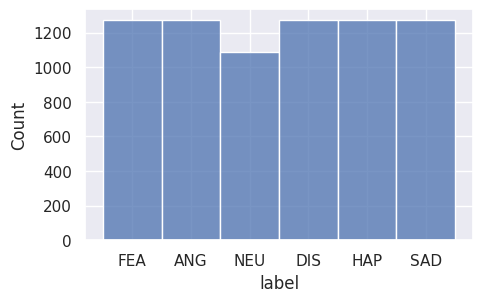

In [18]:
sns.set(rc={'figure.figsize':(5,3)})
sns.set_style('darkgrid')
sns.histplot(labels)

In [19]:
def show_samples(df):
    # Shuffle the DataFrame
    shuffled_df = df.sample(frac=1).reset_index(drop=True)

    # Iterate over unique labels in the shuffled DataFrame
    for label in shuffled_df['label'].unique():
        # Filter DataFrame for the current label
        label_df = shuffled_df[shuffled_df['label'] == label].head(1)  # Take the first example for each label

        # Extract file path and label
        file_path = label_df['file_path'].values[0]
        label = label_df['label'].values[0]

        # Load audio file using librosa
        audio, sr = librosa.load(file_path)

        # Generate the time axis for the waveform
        duration = len(audio) / sr
        time = librosa.times_like(audio, sr=sr)

        # Plot waveform
        plt.plot(time, audio)
        plt.title(f'Waveform for {label}')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.show()
        print()

        # Play the audio
        ipd.display(ipd.Audio(audio, rate=sr))
        print()
        print()

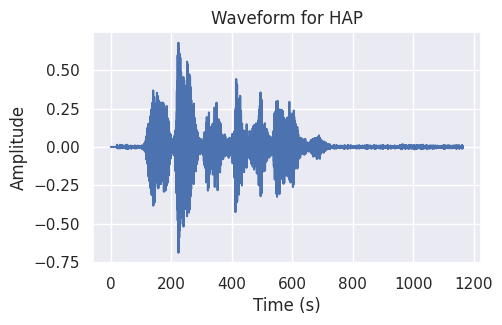

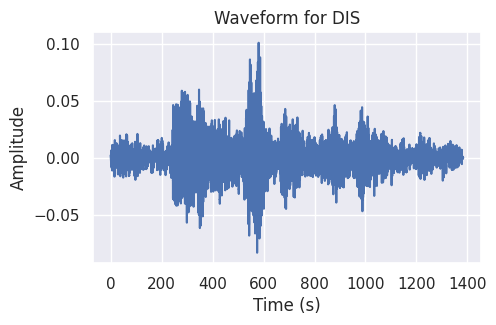

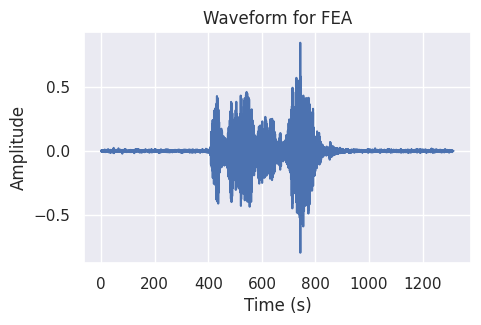

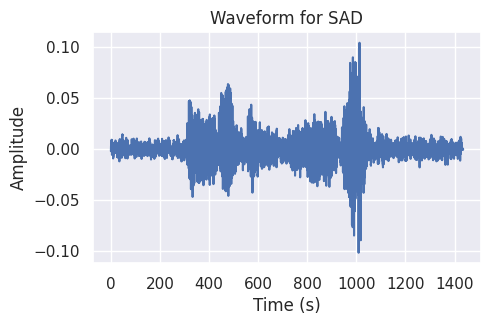

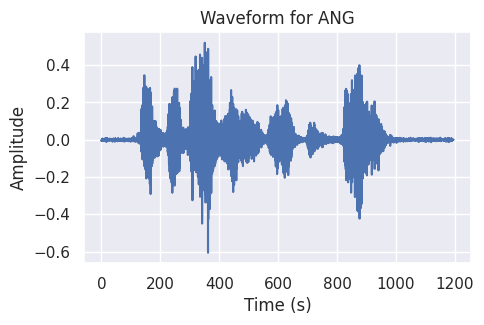

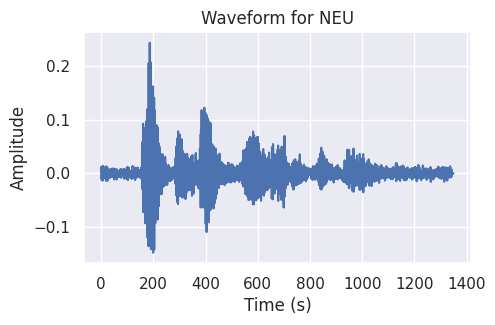

,file_path,label
0,/content/speech-emotion-recognition-en/Crema/1...,FEA
1,/content/speech-emotion-recognition-en/Crema/1...,ANG
2,/content/speech-emotion-recognition-en/Crema/1...,NEU
3,/content/speech-emotion-recognition-en/Crema/1...,FEA
4,/content/speech-emotion-recognition-en/Crema/1...,DIS
...,...,...
7437,/content/speech-emotion-recognition-en/Crema/1...,SAD
7438,/content/speech-emotion-recognition-en/Crema/1...,DIS
7439,/content/speech-emotion-recognition-en/Crema/1...,ANG
7440,/content/speech-emotion-recognition-en/Crema/1...,SAD


In [20]:
show_samples(audio_df)
audio_df

In [21]:
audio_arrays = []

for i in audio_df['file_path']:
    x, sr = librosa.load(i, sr=44100)
    audio_arrays.append(x)

audio_df['Arrays'] = audio_arrays

In [22]:
audio_df

,file_path,label,Arrays
0,/content/speech-emotion-recognition-en/Crema/1...,FEA,"[0.029745229, 0.03730557, 0.033322457, 0.02946..."
1,/content/speech-emotion-recognition-en/Crema/1...,ANG,"[0.0048652226, 0.006127435, 0.0055680196, 0.00..."
2,/content/speech-emotion-recognition-en/Crema/1...,NEU,"[-8.462191e-11, -8.153968e-10, -8.085928e-10, ..."
3,/content/speech-emotion-recognition-en/Crema/1...,FEA,"[0.004865283, 0.0060894457, 0.0054079583, 0.00..."
4,/content/speech-emotion-recognition-en/Crema/1...,DIS,"[-0.0043133586, -0.0055637797, -0.0051581273, ..."
...,...,...,...
7437,/content/speech-emotion-recognition-en/Crema/1...,SAD,"[-0.007096312, -0.009001347, -0.008234806, -0...."
7438,/content/speech-emotion-recognition-en/Crema/1...,DIS,"[-0.0024914837, -0.003183886, -0.0029746382, -..."
7439,/content/speech-emotion-recognition-en/Crema/1...,ANG,"[0.0004218887, 0.000108610664, -0.00039991183,..."
7440,/content/speech-emotion-recognition-en/Crema/1...,SAD,"[-0.003375836, -0.0044364794, -0.0042217867, -..."


In [23]:
def add_noise(data,random=False,rate=0.035,threshold=0.075):
    if random:
        rate=np.random.random()*threshold
    noise=rate*np.random.uniform()*np.amax(data)
    augmented_data=data+noise*np.random.normal(size=data.shape[0])
    return augmented_data

def pitching(data,sr,pitch_factor=0.7,random=False):
    if random:
        pitch_factor=np.random.random() * pitch_factor
    return librosa.effects.pitch_shift(y=data,sr=sr,n_steps=pitch_factor)

In [24]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(y=data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(y=data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(y=data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

In [25]:
def extract_features(data,sr,frame_length=2048,hop_length=512):
    result=np.array([])

    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data,sr)
    audio=np.array(aud)

    noised_audio=add_noise(data,random=True)
    aud2=extract_features(noised_audio,sr)
    audio=np.vstack((audio,aud2))

    pitched_audio=pitching(data,sr,random=True)
    aud3=extract_features(pitched_audio,sr)
    audio=np.vstack((audio,aud3))

    return audio

In [26]:
X, Y = [], []

for path, emotion, index in zip(audio_df.file_path, audio_df.label, range(audio_df.file_path.shape[0])):
    features = get_features(path)
    if index % 500 == 0:
        print(f'{index} audio has been processed')
    for i in features:
        X.append(i)
        Y.append(emotion)

print('Done')

0 audio has been processed
500 audio has been processed
1000 audio has been processed
1500 audio has been processed
2000 audio has been processed
2500 audio has been processed
3000 audio has been processed
3500 audio has been processed
4000 audio has been processed
4500 audio has been processed
5000 audio has been processed
5500 audio has been processed
6000 audio has been processed
6500 audio has been processed
7000 audio has been processed
Done


In [27]:
processed_data_path='./processed_data.csv'

In [28]:
extract=pd.DataFrame(X)
extract['label']=Y
extract.to_csv(processed_data_path,index=False)
extract.head(10)

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,label
0,0.021484,0.028809,0.036133,0.029297,0.036621,0.053223,0.062500,0.067383,0.058594,0.045410,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FEA
1,0.023438,0.033691,0.041992,0.034180,0.042480,0.052734,0.064453,0.071289,0.065430,0.059570,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FEA
2,0.022949,0.028809,0.039551,0.033691,0.032227,0.039551,0.040039,0.039551,0.040527,0.039062,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FEA
3,0.008301,0.014160,0.057617,0.078125,0.089844,0.098633,0.062500,0.044922,0.044922,0.074707,...,-2.267776,4.856338,-11.155014,0.627166,-9.875654,4.365171,-1.203404,-4.189535,-14.423391,ANG
4,0.153809,0.254883,0.341309,0.311523,0.269043,0.221680,0.192871,0.216797,0.252930,0.259277,...,-6.213246,-4.617336,1.839228,1.616948,-4.709631,-2.001520,-1.923622,-4.251989,-6.059234,ANG
5,0.013184,0.028320,0.063965,0.069336,0.076660,0.083496,0.055176,0.060059,0.072754,0.080078,...,-4.387021,0.913518,-7.360200,3.107626,-6.491672,-0.410775,-5.665597,-8.220344,-10.912476,ANG
6,0.026855,0.055176,0.078613,0.081055,0.080566,0.065430,0.052734,0.049316,0.048828,0.055176,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NEU
7,0.027832,0.057617,0.083496,0.085938,0.085449,0.068359,0.053711,0.052246,0.056152,0.066895,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NEU
8,0.029297,0.057617,0.079590,0.082520,0.076660,0.062500,0.056152,0.055176,0.063477,0.068848,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NEU
9,0.017578,0.024414,0.032715,0.032227,0.031250,0.040039,0.043945,0.041504,0.043457,0.036621,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FEA


In [29]:
df=pd.read_csv(processed_data_path)
df.shape

df=df.fillna(0)
print(df.isna().any())
df.shape

0        False
1        False
2        False
3        False
4        False
         ...  
2372     False
2373     False
2374     False
2375     False
label    False
Length: 2377, dtype: bool


(22326, 2377)

In [30]:
X=df.drop(labels='label',axis=1)
Y=df['label']
lb=LabelEncoder()
Y=np_utils.to_categorical(lb.fit_transform(Y))
print(lb.classes_)
Y

['ANG' 'DIS' 'FEA' 'HAP' 'NEU' 'SAD']


array([[0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)

In [31]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,random_state=32,test_size=0.2,shuffle=True)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,random_state=32,test_size=0.1,shuffle=True)
X_train.shape, X_test.shape, X_val.shape, y_train.shape,y_test.shape,y_val.shape

((16074, 2376), (4466, 2376), (1786, 2376), (16074, 6), (4466, 6), (1786, 6))

In [32]:
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)
X_val=scaler.transform(X_val)
X_train.shape,X_test.shape,X_val.shape,y_train.shape,y_test.shape,y_val.shape

((16074, 2376), (4466, 2376), (1786, 2376), (16074, 6), (4466, 6), (1786, 6))

In [33]:
X_train=np.expand_dims(X_train,axis=2)
X_val=np.expand_dims(X_val,axis=2)
X_test=np.expand_dims(X_test,axis=2)
X_train.shape, X_test.shape, X_val.shape

((16074, 2376, 1), (4466, 2376, 1), (1786, 2376, 1))

In [34]:
model = Sequential()

# Convolutional layers
model.add(keras.layers.Conv1D(256, kernel_size=5, strides=1, activation='linear', input_shape=(X_train.shape[1], 1)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))

model.add(keras.layers.Conv1D(128, kernel_size=5, strides=1))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.1))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling1D(pool_size=5, strides = 2))

model.add(keras.layers.Conv1D(128, kernel_size=5, strides=1))
model.add(keras.layers.Activation('relu'))

model.add(keras.layers.Conv1D(128, kernel_size=5, strides=1))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.3))

model.add(keras.layers.Conv1D(128, kernel_size=5, strides=1))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.3))

# Flatten and fully connected layers
model.add(keras.layers.Conv1D(128, kernel_size=5, strides=1))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.7))

model.add(keras.layers.Dense(256, activation='linear'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))


model.add(keras.layers.Dense(6))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('softmax'))

# Optimizer and compile the model
optimizer = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2372, 256)         1536      
                                                                 
 batch_normalization (BatchN  (None, 2372, 256)        1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 2372, 256)         0         
                                                                 
 conv1d_1 (Conv1D)           (None, 2368, 128)         163968    
                                                                 
 batch_normalization_1 (Batc  (None, 2368, 128)        512       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 2368, 128)         0

In [37]:
# Define the callbacks
early_stopping = callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=3, monitor='val_loss', verbose=1)

# Train the model
warnings.filterwarnings("ignore")
history = model.fit(X_train, y_train, epochs=2, batch_size=32,
                    validation_data=(X_val,y_val), callbacks=[early_stopping, reduce_lr])

Epoch 1/2
503/503 [==============================] - 2812s 6s/step - loss: 1.4446 - accuracy: 0.4225 - val_loss: 1.3993 - val_accuracy: 0.4367 - lr: 1.0000e-04
Epoch 2/2
503/503 [==============================] - 2761s 5s/step - loss: 1.3712 - accuracy: 0.4644 - val_loss: 1.3565 - val_accuracy: 0.4709 - lr: 1.0000e-04


In [38]:
val_accuracy = np.mean(history.history['val_accuracy'])
print("\n%s: %.2f%%" % ('val_accuracy', val_accuracy*100))


val_accuracy: 45.38%


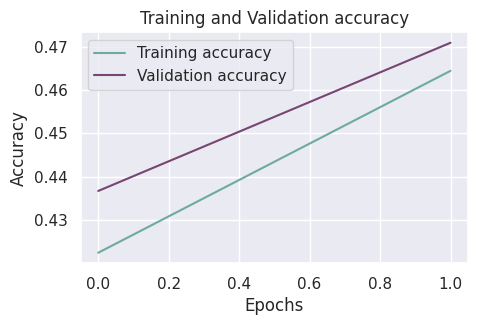

In [39]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], "#6daa9f", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']], "#774571", label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [40]:
# Predicting the test set results
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
np.set_printoptions()

140/140 [==============================] - 141s 1s/step


In [41]:
c_emotions = {
    'NEU':'neutral',
    'HAP':'happy',
    'SAD':'sad',
    'ANG':'angry',
    'FEA':'fear',
    'DIS':'disgust'}

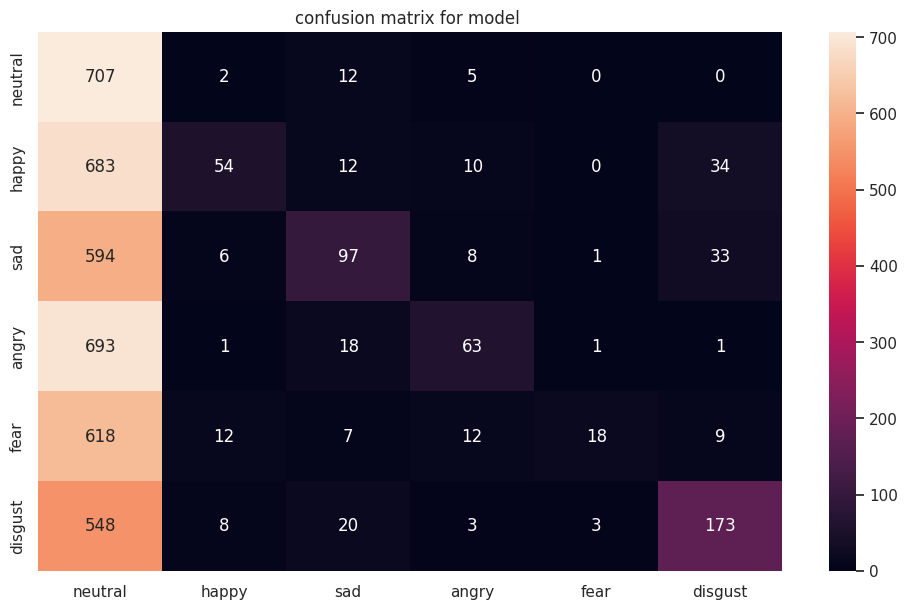

In [42]:
import seaborn as sns
# confusion matrix
y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)
conf=confusion_matrix(y_test_labels,y_pred_labels)
cmap1 = sns.diverging_palette(275,100,  s=40, l=65, n=6)
cm=pd.DataFrame(
    conf,index=[i for i in c_emotions.values()],
    columns=[i for i in c_emotions.values()]
)
plt.figure(figsize=(12,7))
ax=sns.heatmap(cm,annot=True,fmt='d')
ax.set_title(f'confusion matrix for model ')
plt.show()